In [9]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
import torchvision.transforms as transforms
# import cv2
import os
from transformers import AutoTokenizer, AutoModel, DistilBertModel, Trainer, TrainingArguments
from sklearn.metrics import f1_score, roc_auc_score, multilabel_confusion_matrix, accuracy_score
import random
from utils import compute_all_metrics_with_ci

In [10]:
train_dataset = load_from_disk("nlmcxr_labeled_train")
test_dataset = load_from_disk("nlmcxr_labeled_test")

In [11]:
# Load a pretrained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
# tokenizer = AutoTokenizer.from_pretrained("molly-hayward/bioelectra-small-discriminator")

# Define a function to tokenize text
def tokenize_text(text, max_length=128):
    return tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Example: Tokenize a sample text
sample_text = train_dataset[0]["text"]
tokenized_text = tokenize_text(sample_text)
print("Tokenized Text:", tokenized_text["input_ids"].shape)

Tokenized Text: torch.Size([1, 128])


In [12]:
class NLMCXRDataset(Dataset):
    def __init__(self, dataset, tokenizer=None, max_length=128): # Lower max_length for TinyBERT
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        # Process text
        text = sample["text"]
        if self.tokenizer:
            text_tokens = self.tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=self.max_length,
                return_tensors="pt"
            )
            input_ids = text_tokens["input_ids"].squeeze(0)  # Remove batch dim
            attention_mask = text_tokens["attention_mask"].squeeze(0)
        else:
            input_ids = attention_mask = None

        # Process label
        label_vector = torch.tensor(sample['label_vector'], dtype=torch.float32) 

        # Process binary label
        binary_label = torch.tensor(sample['binary_label'], dtype=torch.float32).unsqueeze(0)

        return {
            "text_tokens": text_tokens,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label_vector": label_vector,
            "binary_label": binary_label
        }

# Create dataset objects
train_dataset_pytorch = NLMCXRDataset(train_dataset, tokenizer)
test_dataset_pytorch = NLMCXRDataset(test_dataset, tokenizer)

# Example: Load a sample
sample = train_dataset_pytorch[0]
print("Input IDs Shape:", sample["input_ids"].shape) 
print("Label Vector Shape:", sample["label_vector"].shape) 
print("Binary Label Shape:", sample["binary_label"].shape)

Input IDs Shape: torch.Size([128])
Label Vector Shape: torch.Size([14])
Binary Label Shape: torch.Size([1])


In [13]:
train_subset = Subset(train_dataset_pytorch, random.sample(range(len(train_dataset_pytorch)), 240))
val_subset = Subset(train_dataset_pytorch, random.sample(range(len(train_dataset_pytorch)), 30))
test_subset = Subset(test_dataset_pytorch, random.sample(range(len(test_dataset_pytorch)), 30))

In [14]:
class MultiLabelTinyBertModel(nn.Module):
    def __init__(self, num_labels):
        super(MultiLabelTinyBertModel, self).__init__()

        self.tinybert = AutoModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
        # self.tinybert = AutoModel.from_pretrained("molly-hayward/bioelectra-small-discriminator")

        # Freeze the TinyBERT model parameters
        for param in self.tinybert.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(self.tinybert.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1), # It was 0.3
            nn.Linear(512, num_labels)
        )

    def forward(self, input_ids, attention_mask, label_vector):
        outputs = self.tinybert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled_output)

        if label_vector is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, label_vector)
            return loss, logits

        return logits

In [15]:
model_tinybert = MultiLabelTinyBertModel(num_labels=14)

# Training setup

training_args = TrainingArguments(
    output_dir='./results_tinybert',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=1e-1,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.sigmoid(torch.tensor(logits)) > 0.5
    # accuracy = (preds == torch.tensor(labels)).float().mean().item()
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='micro')
    auc_roc = roc_auc_score(labels, preds, average='micro')
    return {"accuracy": accuracy, "f1": f1, "auc-roc":auc_roc}

trainer = Trainer(
    model=model_tinybert,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_subset,
    eval_dataset=val_subset
)

In [16]:
trainer.train()
print('Training complete.')

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc-roc
1,0.293400,0.292371,0.233333,0.229508,0.572401
2,0.281500,0.257160,0.200000,0.260870,0.577165
3,0.274700,0.291173,0.033333,0.052632,0.513514
4,0.291700,0.281152,0.000000,0.000000,0.500000
5,0.262500,0.266101,0.100000,0.186047,0.551443
6,0.304600,0.275225,0.233333,0.301887,0.597664
7,0.271800,0.268955,0.000000,0.000000,0.500000
8,0.276900,0.265183,0.000000,0.000000,0.500000
9,0.263200,0.264599,0.000000,0.000000,0.500000
10,0.254400,0.264044,0.000000,0.000000,0.500000


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [17]:
torch.save(model_tinybert.state_dict(), 'tinybert_chest_model.pth')

In [18]:
# Save the model
trainer.save_model()

# Evaluate
trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2752254605293274,
 'eval_accuracy': 0.23333333333333334,
 'eval_f1': 0.3018867924528302,
 'eval_auc-roc': 0.5976642438783432,
 'eval_runtime': 0.6293,
 'eval_samples_per_second': 47.67,
 'eval_steps_per_second': 6.356,
 'epoch': 10.0}

In [19]:
model_tinybert.load_state_dict(torch.load("tinybert_chest_model.pth"))

<All keys matched successfully>

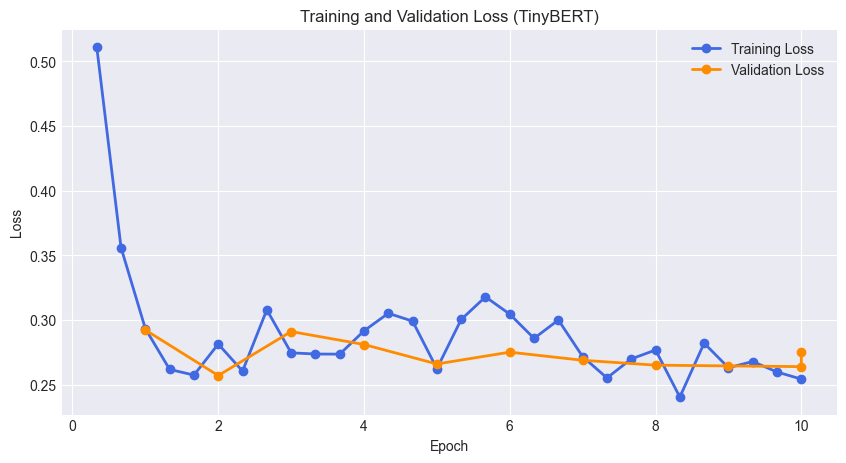

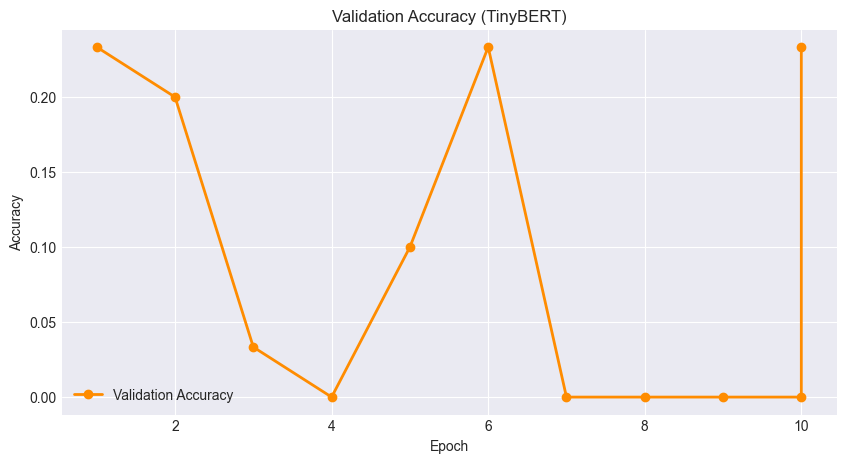

In [20]:
# Extract logs
logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []
train_epochs = []
eval_epochs = []

for log in logs:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])  # store matching epoch
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.style.use('seaborn-v0_8-darkgrid')
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label="Training Loss", marker='o', linewidth=2, color='royalblue')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o', linewidth=2, color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (TinyBERT)")
plt.legend()
plt.grid(True)
plt.savefig("tinybert_chest_loss.png")
plt.show()

# Plot Accuracy (optional, if accuracy was computed)
if eval_accuracy:
    plt.figure(figsize=(10, 5))
    plt.plot(eval_epochs[:len(eval_accuracy)], eval_accuracy, label="Validation Accuracy", marker='o', linewidth=2, color='darkorange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy (TinyBERT)")
    plt.legend()
    plt.grid(True)
    plt.savefig("tinybert_chest_accuracy.png")
    plt.show()

In [21]:
# Use the Trainer's predict method on the test dataset
predictions = trainer.predict(test_subset)

# Extract logits and labels
logits = predictions.predictions
all_labels = predictions.label_ids

# Convert logits to binary predictions
binary_preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()

print("All Labels Shape:", all_labels.shape)
print("Binary Predictions Shape:", binary_preds.shape)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


All Labels Shape: (30, 14)
Binary Predictions Shape: (30, 14)


In [22]:
y_true = all_labels
y_pred = binary_preds
y_pred_probs = torch.sigmoid(torch.tensor(logits)).numpy()

results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=True)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

accuracy: 0.297 (90% CI: 0.167 - 0.433)
f1: 0.338 (90% CI: 0.189 - 0.490)
auroc: 0.788 (90% CI: 0.707 - 0.862)
mcc: 0.322 (90% CI: 0.156 - 0.491)
brier: 0.072 (90% CI: 0.056 - 0.088)
sensitivity: 0.040 (90% CI: 0.025 - 0.054)
specificity: 0.971 (90% CI: 0.955 - 0.985)
balanced_accuracy: 0.505 (90% CI: 0.494 - 0.516)


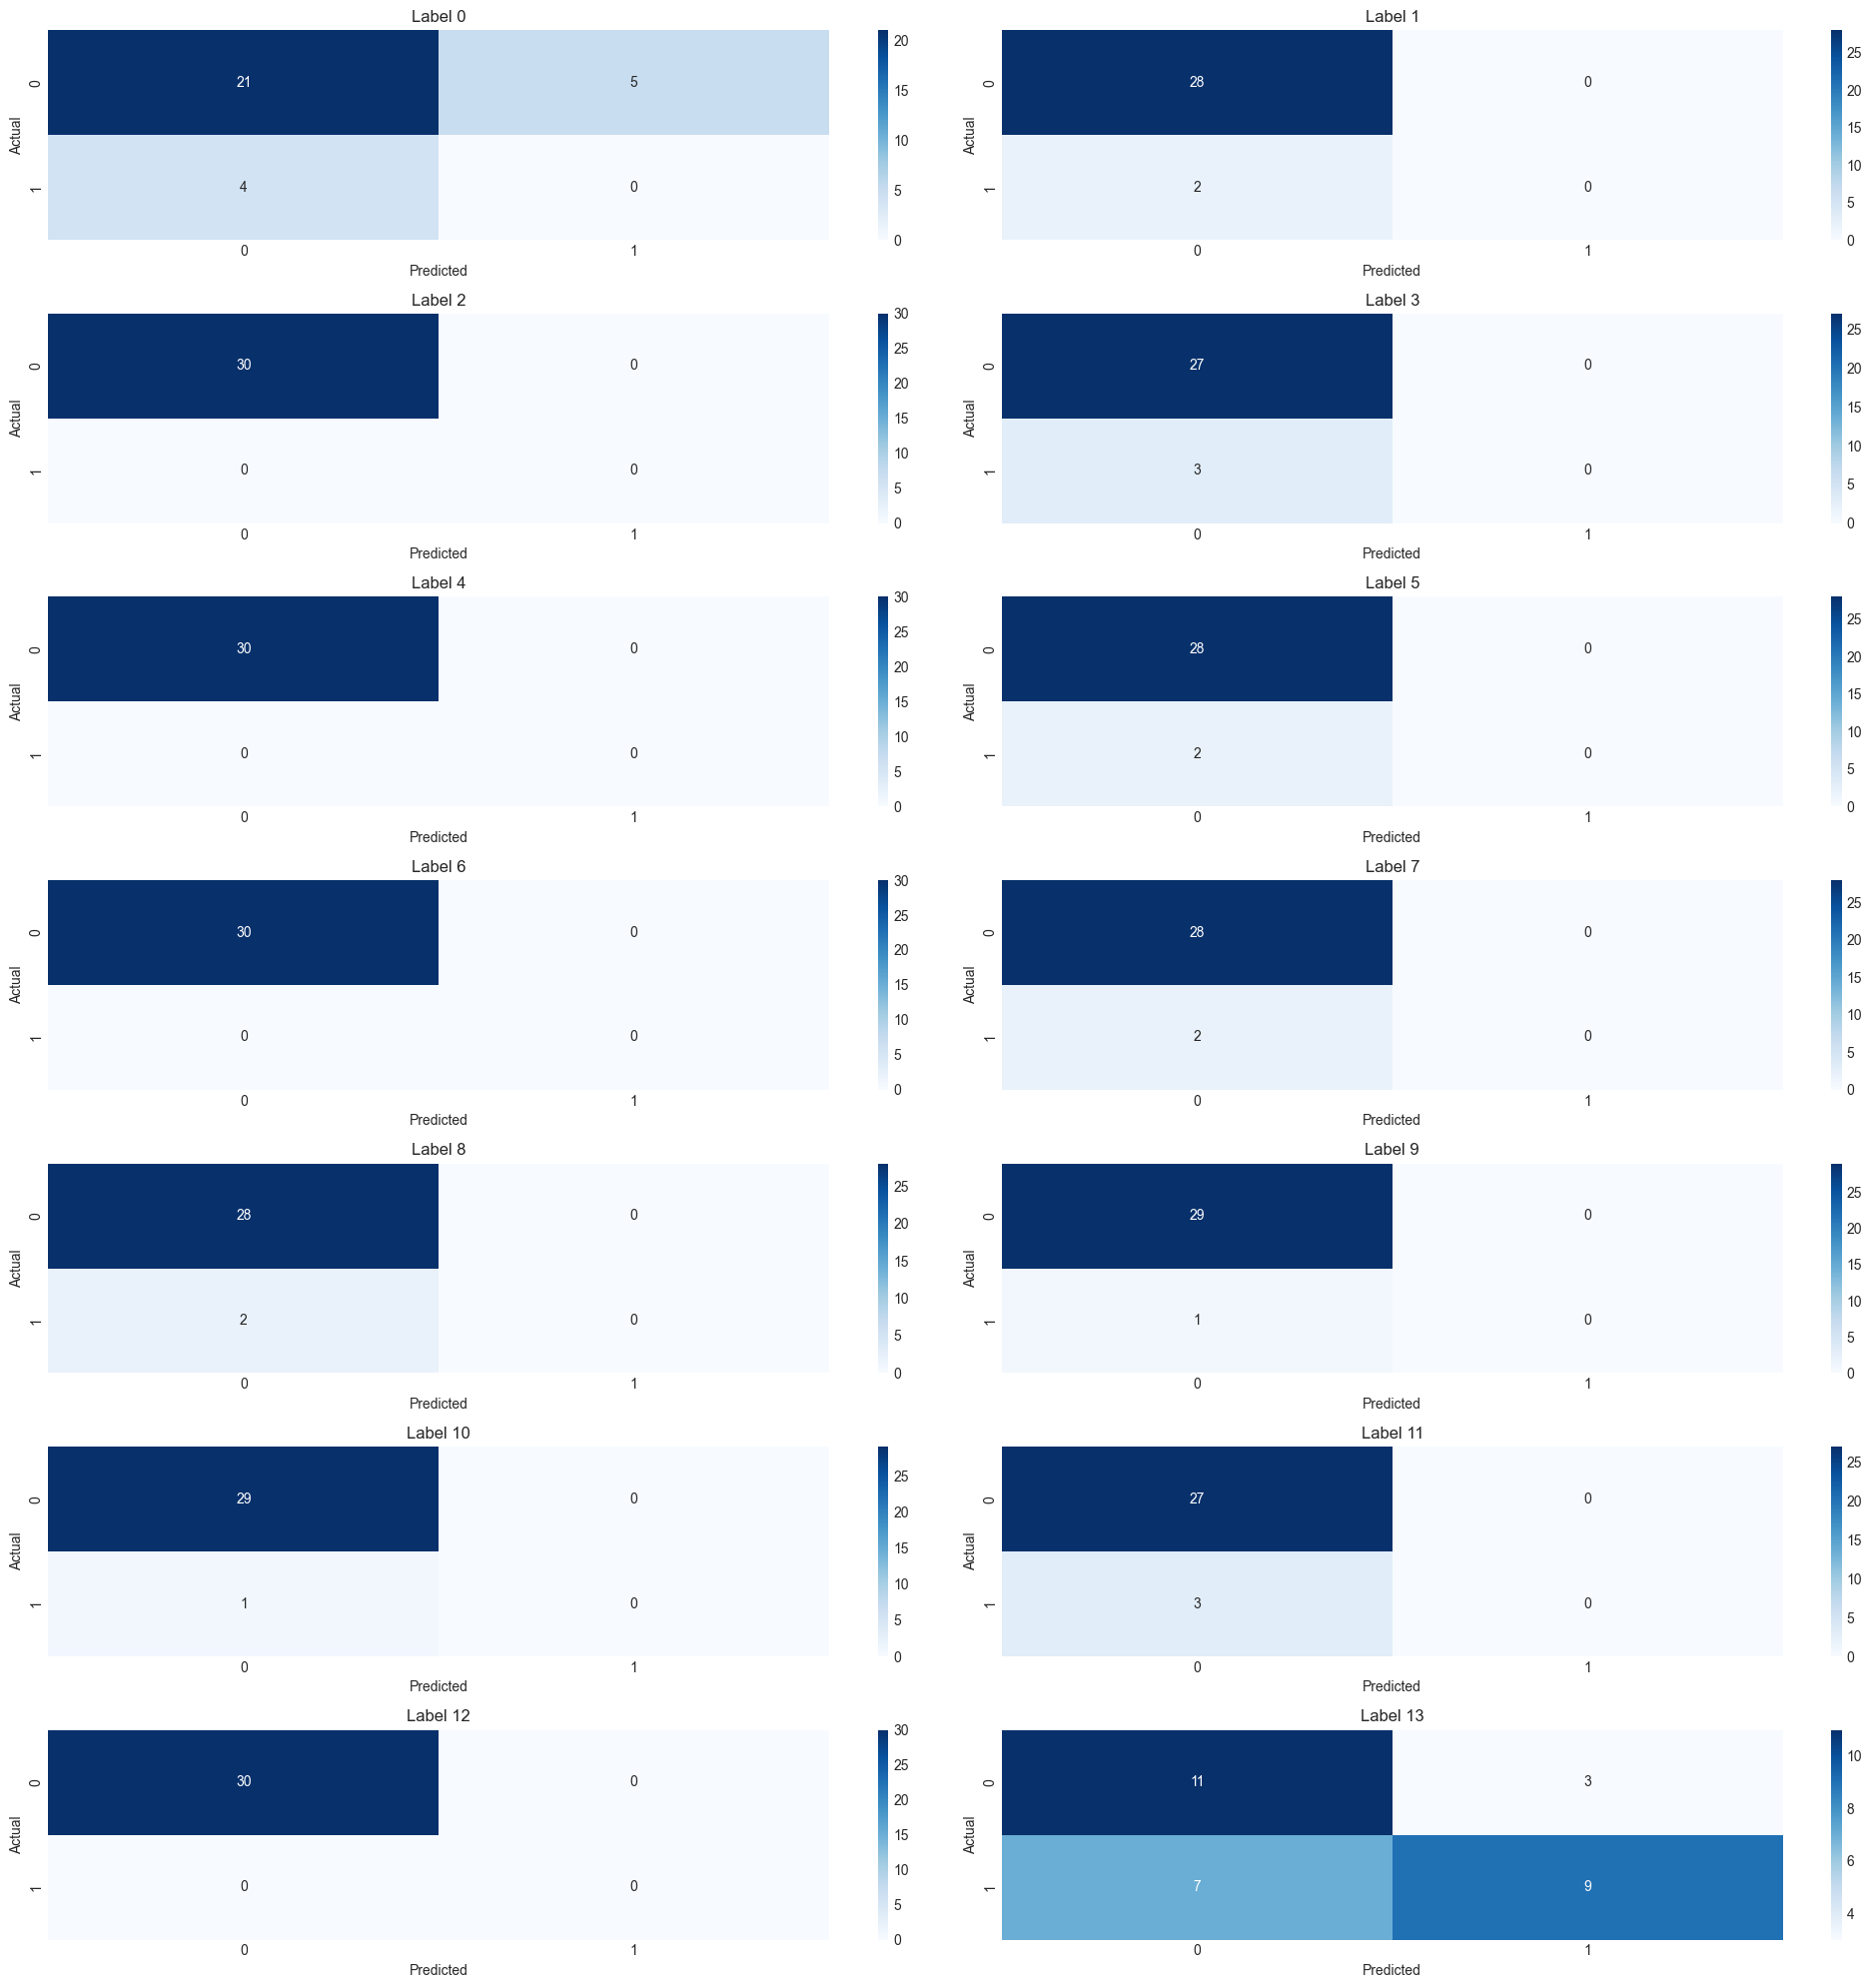

In [23]:
# Assuming `all_labels` and `binary_preds` are available from the evaluation function
# Compute the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(all_labels, binary_preds)

# Plot each confusion matrix
fig, axes = plt.subplots(7, 2, figsize=(20, 20))

axes = axes.flatten()

for i, ax in enumerate(axes):
    cm = confusion_matrices[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Label {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig("tinybert_chest_confusion_matrices.png")
plt.show()

In [24]:
class_names = [
    "Atelectasis",
    "Consolidation",
    "Infiltration",
    "Pneumothorax",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Effusion",
    "Pneumonia",
    "Pleural_thickening",
    "Cardiomegaly",
    "Nodule Mass",
    "Hernia",
    "No Finding"
]

print("Class Names:", class_names)

Class Names: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_thickening', 'Cardiomegaly', 'Nodule Mass', 'Hernia', 'No Finding']


In [25]:
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    brier_score_loss
)

def compute_additional_metrics(labels, preds):
    
    metrics = {
        "micro_f1": f1_score(labels, preds, average="micro"),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "roc_auc_micro": roc_auc_score(labels, preds, average="micro"),
        "matthews_corrcoef_micro": matthews_corrcoef(labels.flatten(), preds.flatten()),
    }

    # Compute brier score for each class
    brier_scores = []
    for i in range(labels.shape[1]):
        brier_scores.append(brier_score_loss(labels[:, i], preds[:, i]))
    
    metrics["brier_score_avg"] = sum(brier_scores) / len(brier_scores)

    sensitivities = []
    specificities = []
    balanced_accuracies = []

    for cm in confusion_matrices:
        TN, FP, FN, TP = cm.ravel()

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        balanced_accuracy = (sensitivity + specificity) / 2

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        balanced_accuracies.append(balanced_accuracy)

    metrics["sensitivity_avg"] = sum(sensitivities) / len(sensitivities)
    metrics["specificity_avg"] = sum(specificities) / len(specificities)
    metrics["balanced_accuracy_avg"] = sum(balanced_accuracies) / len(balanced_accuracies)

    return metrics


In [26]:
metrics = compute_additional_metrics(all_labels, binary_preds)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
# Print the metrics
print("Micro F1 Score:", metrics["micro_f1"])
print("ROC AUC Score (Micro):", metrics["roc_auc_micro"])
print("Matthews Correlation Coefficient (Micro):", metrics["matthews_corrcoef_micro"])
print("Brier Score (Average):", metrics["brier_score_avg"])
print("Sensitivity (Average):", metrics["sensitivity_avg"])
print("Specificity (Average):", metrics["specificity_avg"])
print("Balanced Accuracy (Average):", metrics["balanced_accuracy_avg"])


Micro F1 Score: 0.33962264150943394
ROC AUC Score (Micro): 0.6145833333333333
Matthews Correlation Coefficient (Micro): 0.3255302311566106
Brier Score (Average): 0.08333333333333333
Sensitivity (Average): 0.04017857142857143
Specificity (Average): 0.9709576138147566
Balanced Accuracy (Average): 0.505568092621664


In [28]:
sample_idx = 10  # Change this to view a different sample
print(f"Confidence scores for test sample {sample_idx}:")
print("Per-class confidence scores:", y_pred_probs[sample_idx])
print("Predicted labels:", y_pred[sample_idx])
print("Ground truth labels:", y_true[sample_idx])

Confidence scores for test sample 10:
Per-class confidence scores: [1.2404395e-01 2.5679566e-07 5.1348121e-07 1.8783996e-01 1.7438061e-03
 1.8599289e-02 2.0442776e-04 1.4864407e-01 4.6986756e-03 1.6482749e-05
 4.2094928e-01 2.2904765e-02 3.3648545e-03 6.8619907e-01]
Predicted labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Ground truth labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
